# Model Experimentation & Interpretation with SHAP

This notebook documents the core of our predictive modeling efforts for the Proactive Customer Retention project. Building on the cleaned and analyzed dataset from our Exploratory Data Analysis, our objective here is to build a complete, end-to-end system that moves from prediction to interpretation to action.

We will accomplish this through a four-step process:
1. Model Bake-Off: Conduct a structured "bake-off" to train and rigorously evaluate a diverse lineup of powerful classification models. This ensures our final model choice is not just high-performing but also robust and well-justified.
2. Champion Model Selection: Select the single best model based on metrics that are directly relevant to the business goal of identifying at-risk customers.
3. Explainable AI (XAI) with SHAP: Use the state-of-the-art SHAP (SHapley Additive exPlanations) library to translate our champion model's "black box" logic into clear, human-understandable insights. We will answer not just who will churn, but why.
4. Actionable Loyalty Profiles: Synthesize these SHAP insights into data-driven customer personas. This segmentation will form the strategic foundation for the personalized retention emails in Part II of our project.

### Algorithms:

- Random Forest: A powerful and robust ensemble model that serves as a strong baseline, less prone to overfitting than a single decision tree.
- XGBoost (Extreme Gradient Boosting): The industry gold standard for structured, tabular data. It is an advanced ensemble technique known for its exceptional performance and efficiency.
- Deep Neural Network (DNN): A deep learning approach designed to capture complex, non-linear patterns in the data. 

### Evaluation Strategy
Due to class imbalance, we prioritize metrics beyond Accuracy:

- AUC-ROC: Overall separability.

- Recall (Churn class): Critical for retention impact.

- F1-Score (Churn class): Balanced effectiveness.

## Part 1: Model Experimentation

1. Imports and Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import os

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier # New
from xgboost import XGBClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Evaluation
from sklearn.metrics import classification_report, roc_auc_score, precision_score, recall_score, f1_score


2025-08-18 16:24:05.941971: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755534245.957290   22760 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755534245.961934   22760 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1755534245.974496   22760 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1755534245.974511   22760 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1755534245.974514   22760 computation_placer.cc:177] computation placer alr

In [2]:
# --- Define Churn Colors ---
NO_CHURN_COLOR = '#FF004F'
CHURN_COLOR = '#00FFBF'
# Add a third color for visualizations
NEUTRAL_COLOR = '#8C8C8C'

# Ensure the directory existence
os.makedirs('data', exist_ok=True)
os.makedirs('figures', exist_ok=True)

2. Data Loading and Preparation

In [3]:
df = pd.read_csv('data/Vodafone_Customer_Churn_Sample_Dataset.csv')

df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(0, inplace=True)
df['Churn'] = df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)
df.drop('customerID', axis=1, inplace=True)

X = df.drop('Churn', axis=1)
y = df['Churn']

numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(include='object').columns.tolist()


# === Preprocessing Pipeline ===
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


3. Model Training

In [4]:
# --- Model 1: Random Forest ---
rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced', n_estimators=150))])
print("Training Random Forest model...")
rf_pipeline.fit(X_train, y_train)
print("Done.\n")

# --- Model 2: XGBoost (Industry Standard) ---
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]
xgb_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', XGBClassifier(random_state=42, use_label_encoder=False, 
                                                            eval_metric='logloss', scale_pos_weight=scale_pos_weight))])
print("Training XGBoost model...")
xgb_pipeline.fit(X_train, y_train)
print("Done.\n")

# --- Model 3: Neural Network ---
X_train_processed = rf_pipeline.named_steps['preprocessor'].transform(X_train)
X_test_processed = rf_pipeline.named_steps['preprocessor'].transform(X_test)
input_shape = X_train_processed.shape[1]

def nn_model(input_dim):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(64, activation='relu'), BatchNormalization(), Dropout(0.4),
        Dense(32, activation='relu'), BatchNormalization(), Dropout(0.4),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC(name='auc')])
    return model

nn_model = nn_model(input_shape)
class_weight_0 = (1 / y_train.value_counts()[0]) * (len(y_train) / 2.0)
class_weight_1 = (1 / y_train.value_counts()[1]) * (len(y_train) / 2.0)
nn_class_weights = {0: class_weight_0, 1: class_weight_1}

early_stopping = EarlyStopping(monitor='val_auc', patience=25, mode='max', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_auc', factor=0.2, patience=5, min_lr=0.00001, mode='max')

print("\nTraining Neural Network model...")
history = nn_model.fit(X_train_processed, y_train, epochs=200, batch_size=32, validation_split=0.2,
                                class_weight=nn_class_weights, callbacks=[early_stopping, reduce_lr], verbose=0)
print("Done. Model training stopped at epoch:", early_stopping.stopped_epoch)

Training Random Forest model...
Done.

Training XGBoost model...
Done.



2025-08-18 16:24:09.218953: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)



Training Neural Network model...
Done. Model training stopped at epoch: 38


4. Model Evaluation

In [5]:
# Get predictions
rf_preds = rf_pipeline.predict(X_test)
xgb_preds = xgb_pipeline.predict(X_test)
nn_preds_proba = nn_model.predict(X_test_processed).flatten()
nn_preds = (nn_preds_proba > 0.5).astype(int)

# Get prediction probabilities for AUC
rf_preds_proba = rf_pipeline.predict_proba(X_test)[:, 1]
xgb_preds_proba = xgb_pipeline.predict_proba(X_test)[:, 1]

# Store results in a dictionary
results = {
    'Random Forest': {
        'AUC': roc_auc_score(y_test, rf_preds_proba),
        'F1 (Churn)': f1_score(y_test, rf_preds, pos_label=1),
        'Recall (Churn)': recall_score(y_test, rf_preds, pos_label=1),
        'Precision (Churn)': precision_score(y_test, rf_preds, pos_label=1)
    },
    'XGBoost': {
        'AUC': roc_auc_score(y_test, xgb_preds_proba),
        'F1 (Churn)': f1_score(y_test, xgb_preds, pos_label=1),
        'Recall (Churn)': recall_score(y_test, xgb_preds, pos_label=1),
        'Precision (Churn)': precision_score(y_test, xgb_preds, pos_label=1)
    },
    'Neural Network': {
        'AUC': roc_auc_score(y_test, nn_preds_proba),
        'F1 (Churn)': f1_score(y_test, nn_preds, pos_label=1),
        'Recall (Churn)': recall_score(y_test, nn_preds, pos_label=1),
        'Precision (Churn)': precision_score(y_test, nn_preds, pos_label=1)
    }
}

# Print the results
print("\n" + "="*60)
print("              Final Model Performance")
print("="*60)
for model_name, metrics in results.items():
    print(f"\n--- {model_name} ---")
    for metric_name, value in metrics.items():
        print(f"{metric_name}: {value:.4f}")
print("="*60)


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

              Final Model Performance

--- Random Forest ---
AUC: 0.8213
F1 (Churn): 0.5465
Recall (Churn): 0.4866
Precision (Churn): 0.6233

--- XGBoost ---
AUC: 0.8187
F1 (Churn): 0.5877
Recall (Churn): 0.6631
Precision (Churn): 0.5277

--- Neural Network ---
AUC: 0.8405
F1 (Churn): 0.6200
Recall (Churn): 0.7941
Precision (Churn): 0.5086


5. Results Visualisation and Saving


Chart saved successfully as 'figures/model_performance_comparison.png'


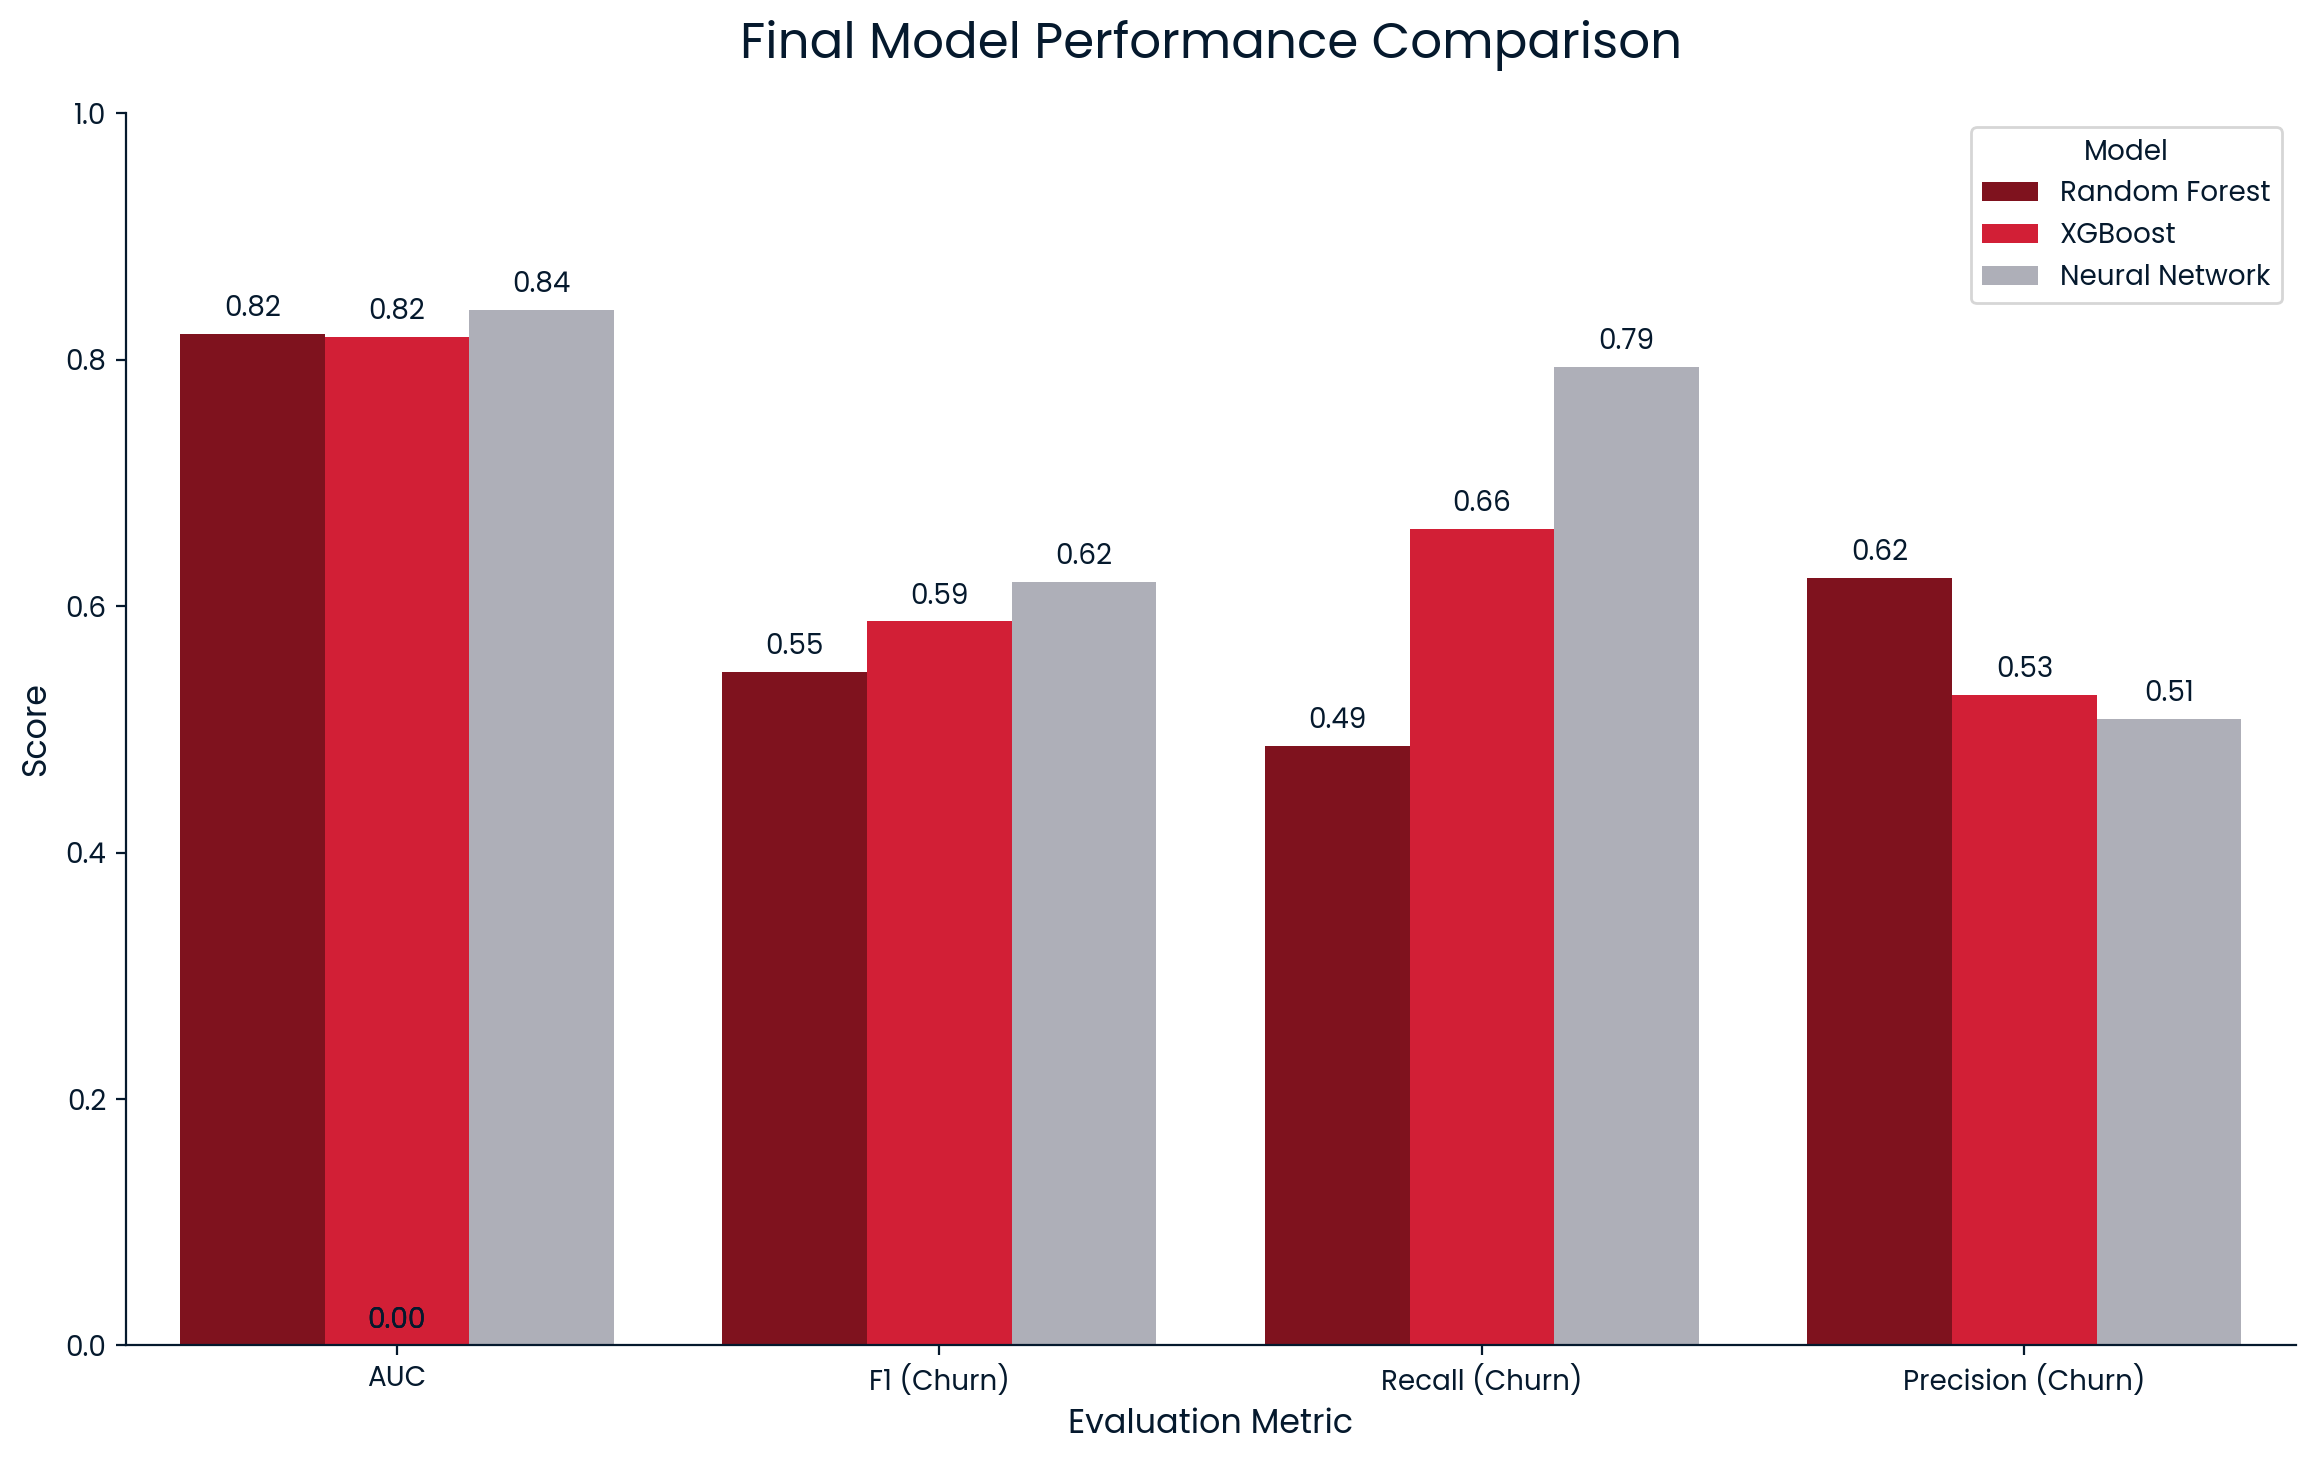

In [19]:
# Convert results dictionary to a DataFrame for easier plotting
results_df = pd.DataFrame(results).T.reset_index().rename(columns={'index': 'Model'})
results_melted = results_df.melt(id_vars='Model', var_name='Metric', value_name='Score')

# Create the plot
plt.figure(figsize=(14, 8))
ax = sns.barplot(data=results_melted, x='Metric', y='Score', hue='Model', 
                 palette=['#910010', '#F00120', '#ACAEBA', '#E3001E']) # A palette derived from our brand colors

# Add annotations
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

# Customize and save
plt.title('Final Model Performance Comparison', fontsize=18, pad=20)
plt.xlabel('Evaluation Metric', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.ylim(0, 1.0)
plt.legend(title='Model', fontsize=10)
sns.despine()

# Save the figure to a PNG file
output_filename = 'figures/model_performance_comparison.png'
plt.savefig(output_filename, dpi=300, bbox_inches='tight')
print(f"\nChart saved successfully as '{output_filename}'")

plt.show()

## Part 2: Model Interpretation with SHAP

In [7]:
# SHAP expects numpy arrays (you already have X_train_processed and X_test_processed)
#background = X_train_processed[np.random.choice(X_train_processed.shape[0], 100, replace=False)]

#explainer = shap.DeepExplainer(nn_model, background)
#shap_values = explainer.shap_values(X_test_processed[:200])  # subset for speed

SHAP values shape: (200, 45)
X_test_sample shape: (200, 45)


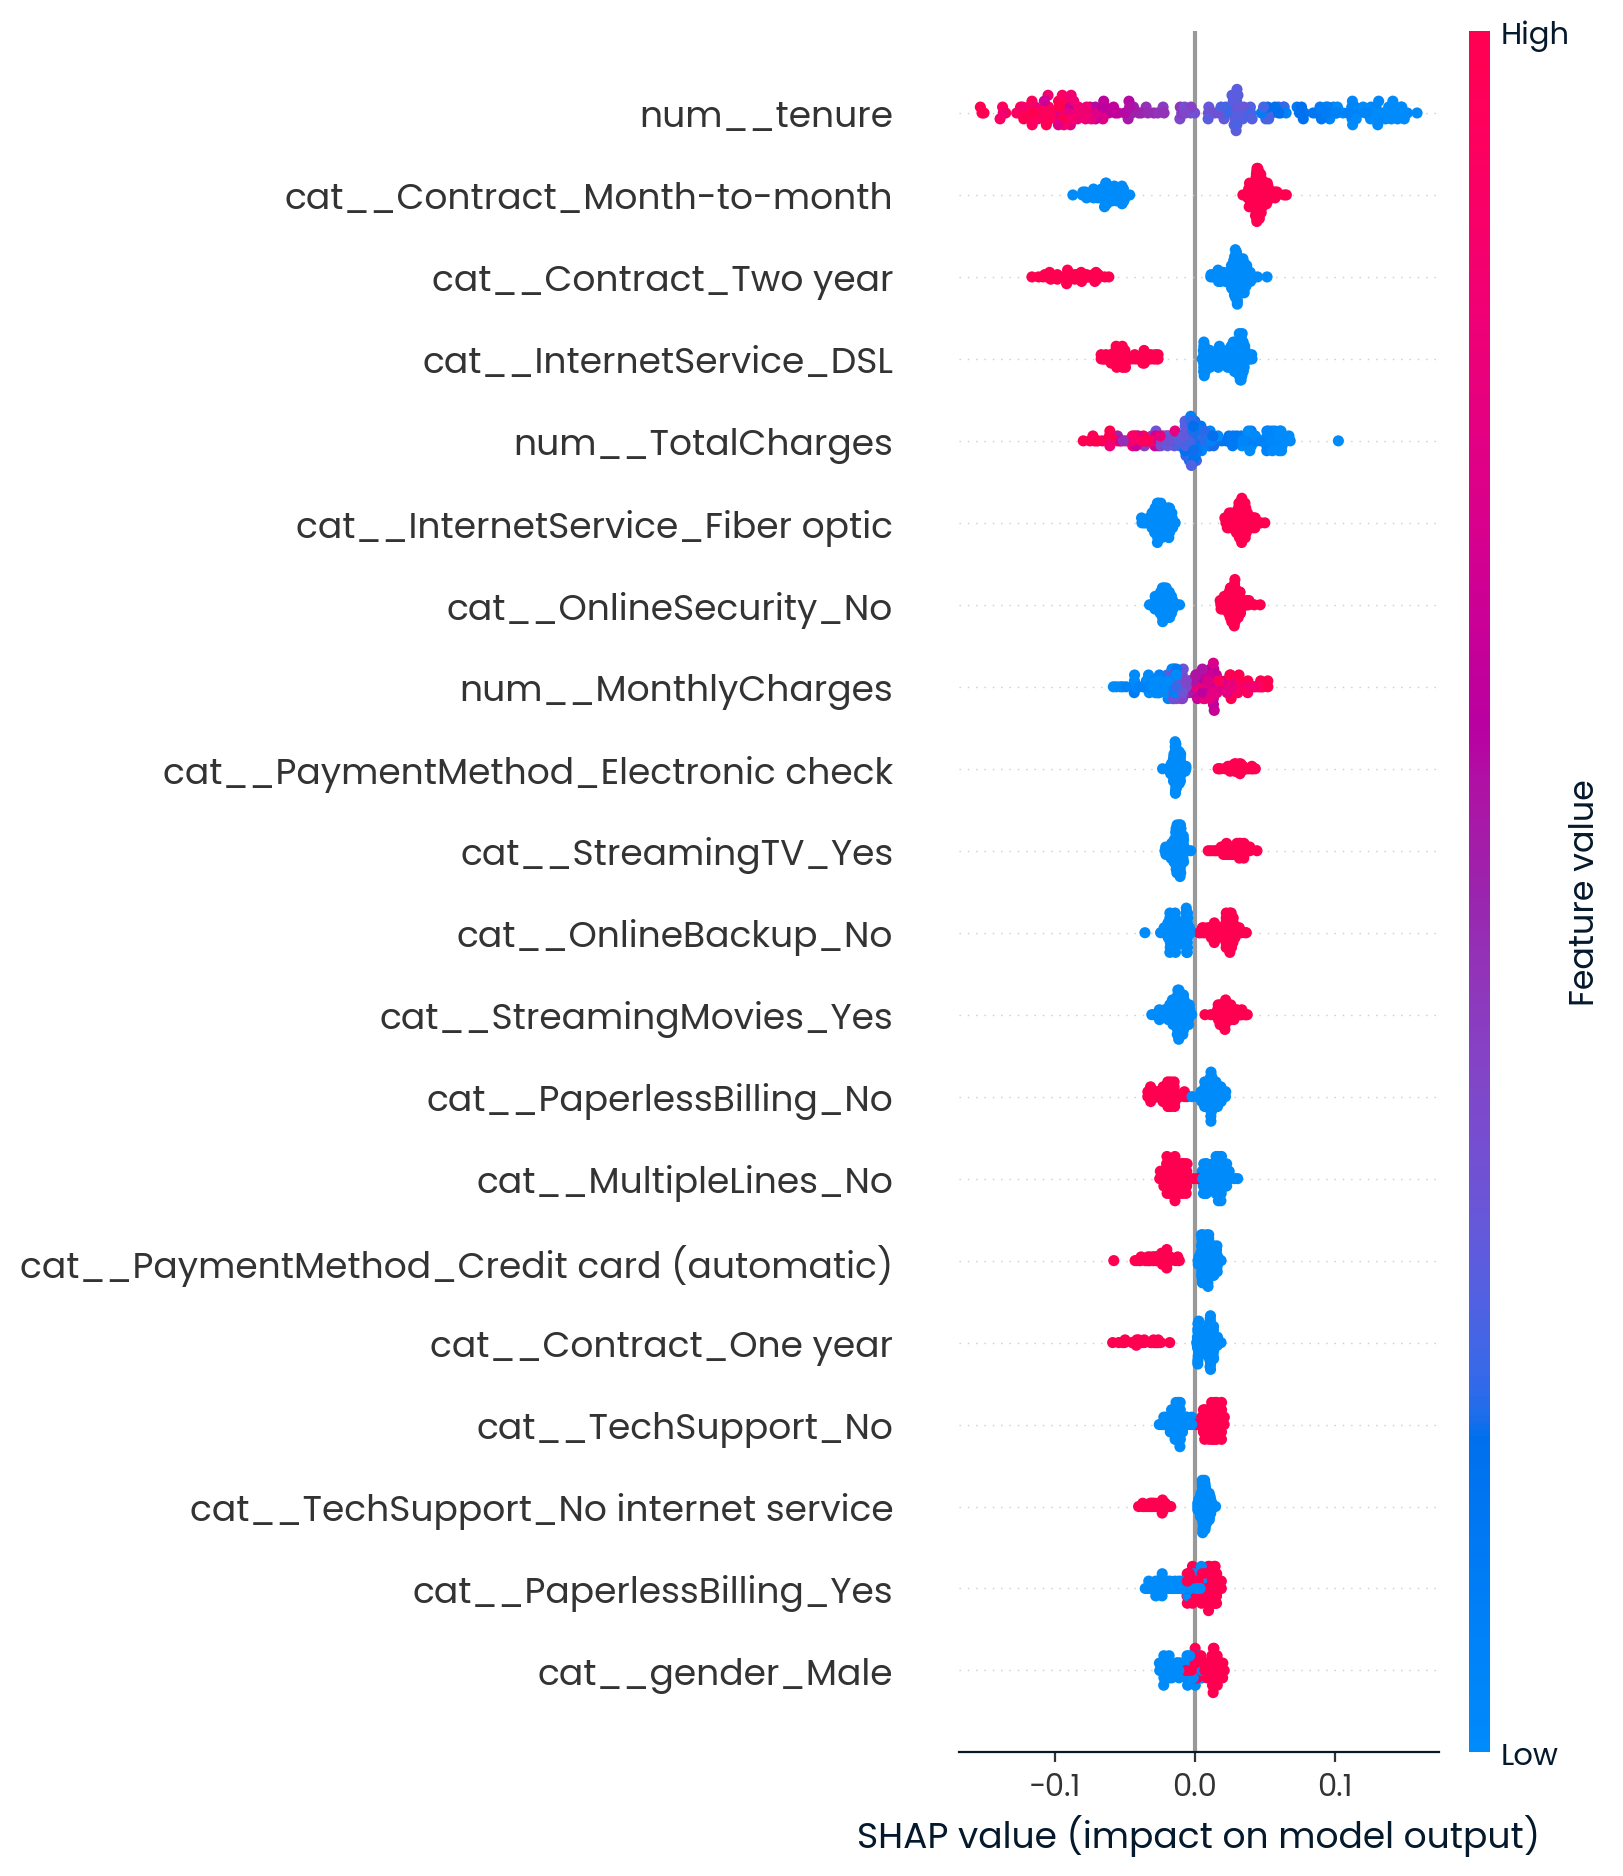

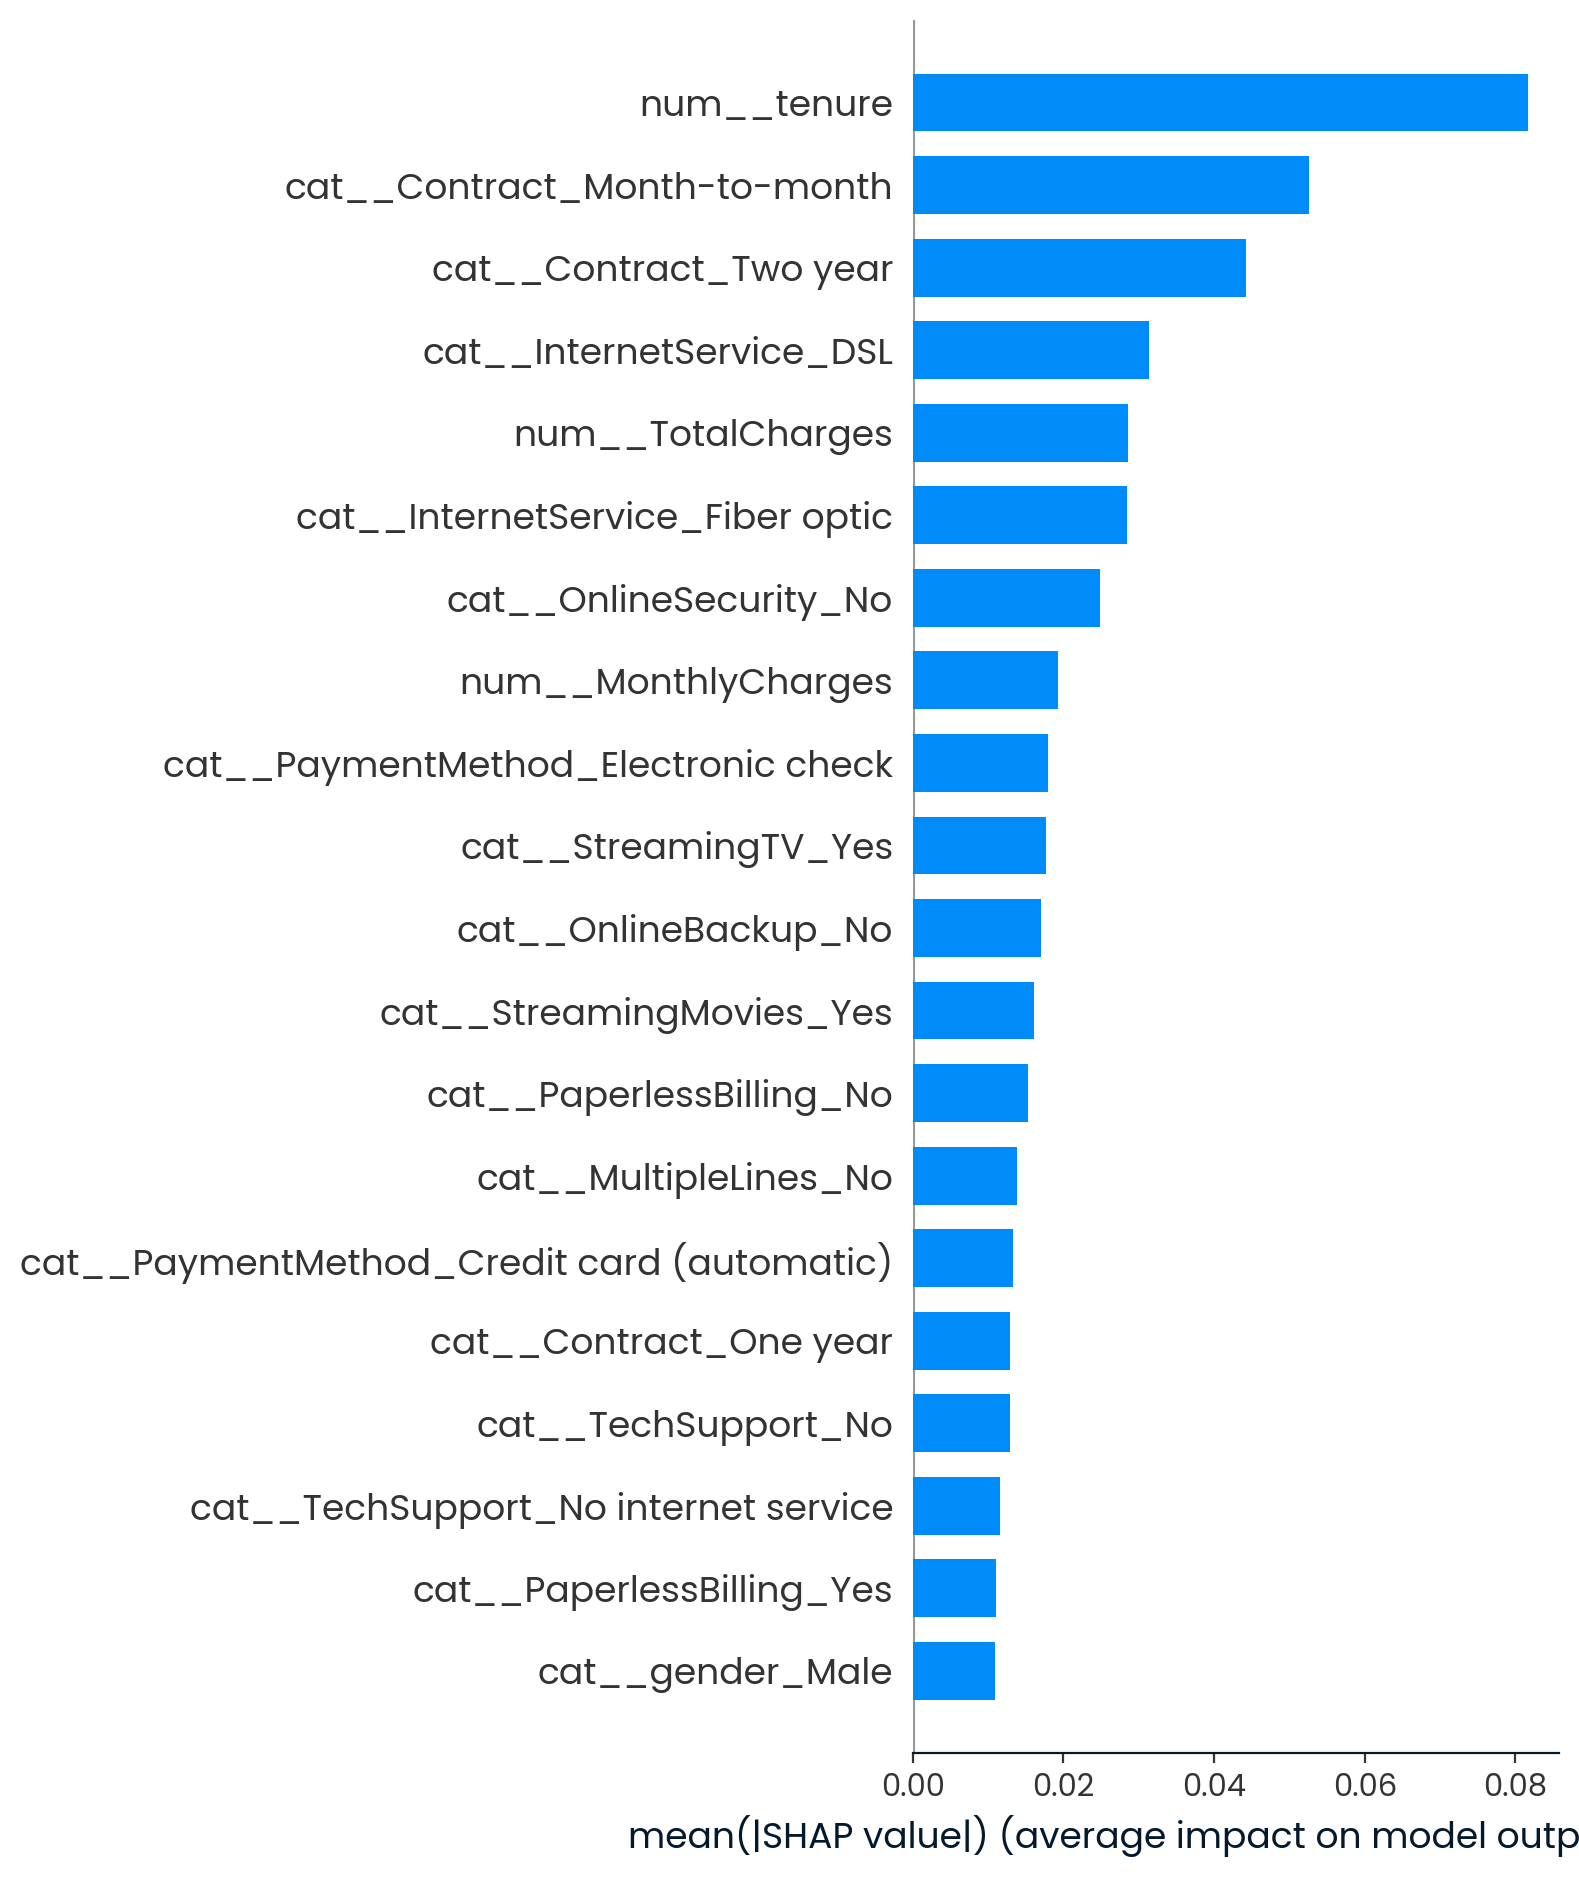

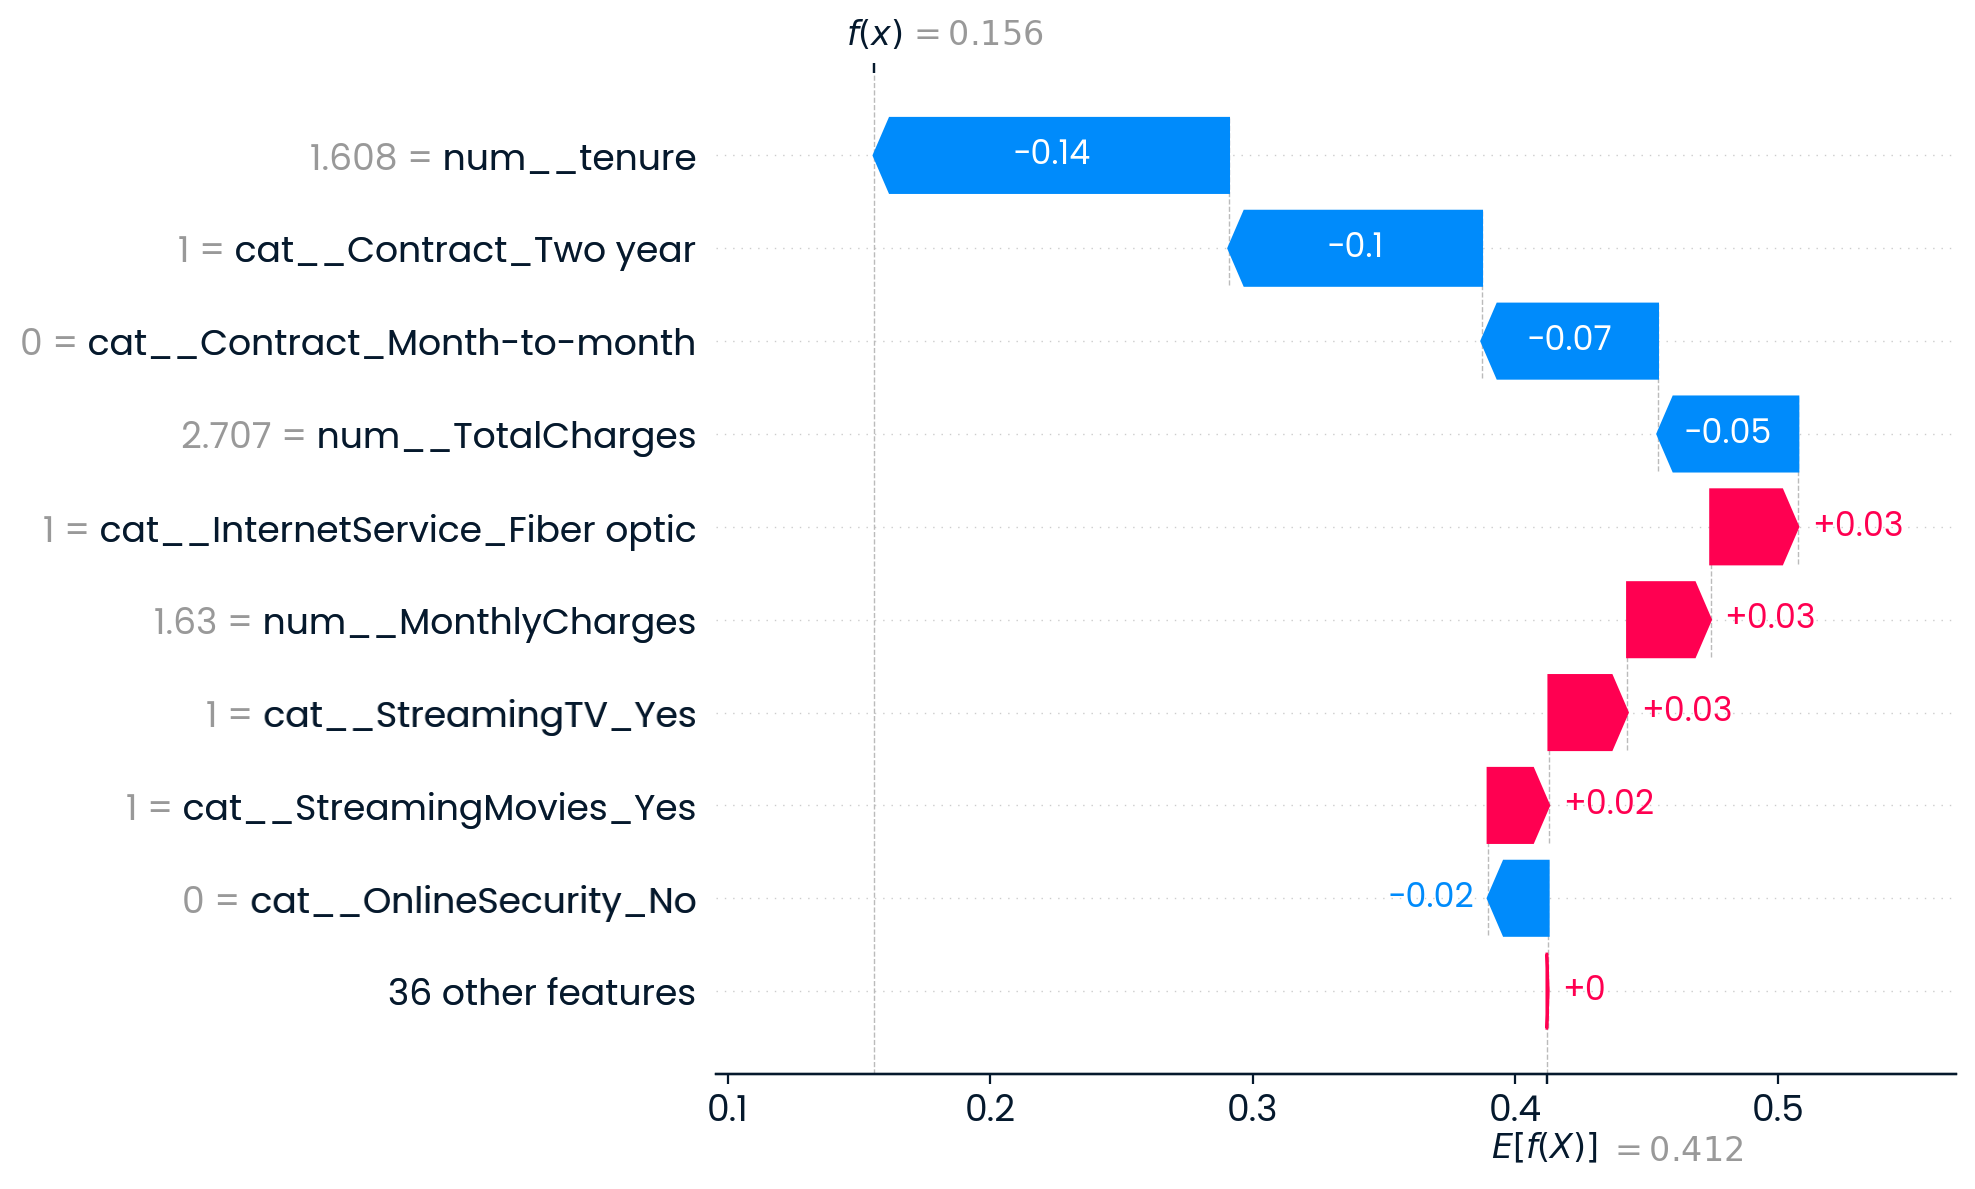

In [14]:
# Take a sample for faster SHAP calculation
X_test_sample = X_test_processed[:200]

# Create the DeepExplainer
explainer = shap.DeepExplainer(nn_model, X_train_processed[:200])

# Compute SHAP values
shap_values = explainer.shap_values(X_test_sample)

# --- Handle single-output NN DeepExplainer output ---
if isinstance(shap_values, list):
    shap_values = np.array(shap_values[0])  # take first output

# --- Reshape (n_samples, n_features, 1) -> (n_samples, n_features) if needed ---
if shap_values.ndim == 3 and shap_values.shape[2] == 1:
    shap_values = shap_values.reshape(shap_values.shape[0], shap_values.shape[1])

print("SHAP values shape:", shap_values.shape)
print("X_test_sample shape:", X_test_sample.shape)

# --- Feature names ---
num_features = shap_values.shape[1]  # automatically get number of features
feature_names = preprocessor.get_feature_names_out()  # flat list
assert shap_values.shape[1] == len(feature_names)

# --- Summary plot (beeswarm) ---
plt.figure()  # Create a new figure
shap.summary_plot(shap_values, X_test_sample, feature_names=feature_names)
plt.savefig("figures/shap_plot_beeswarm.png", bbox_inches="tight", dpi=300)
plt.close()

# --- Summary bar plot ---
plt.figure()  # Create a new figure
shap.summary_plot(shap_values, X_test_sample, feature_names=feature_names, plot_type="bar")
plt.savefig("figures/shap_plot_bar.png", bbox_inches="tight", dpi=300)
plt.close()

i = 0  # index of the instance

# Convert SHAP values and features to NumPy arrays
sv = np.array(shap_values[i], dtype=float)
x = np.array(X_test_sample[i], dtype=float)

# Ensure expected_value is a scalar
expected_value = explainer.expected_value
if isinstance(expected_value, (list, np.ndarray, tf.Tensor)):
    expected_value = float(np.array(expected_value)[0] if isinstance(expected_value, (list, np.ndarray)) else expected_value.numpy())

# Generate Matplotlib-based waterfall plot
plt.figure()  # Create a new figure
shap.waterfall_plot(
    shap.Explanation(
        values=sv,
        base_values=expected_value,
        data=x,
        feature_names=feature_names
    )
)
plt.savefig("figures/shap_plot_waterfall.png", bbox_inches="tight", dpi=300)
plt.close()

Creating Loyalty Profiles

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

Distribution of Customer Loyalty Profiles (from sample):
loyalty_profile
Loyal Champion        61
Stable Customer       57
General Churn Risk    32
New & Uncertain       32
Freedom Seeker        17
At-Risk VIP            1
Name: count, dtype: int64


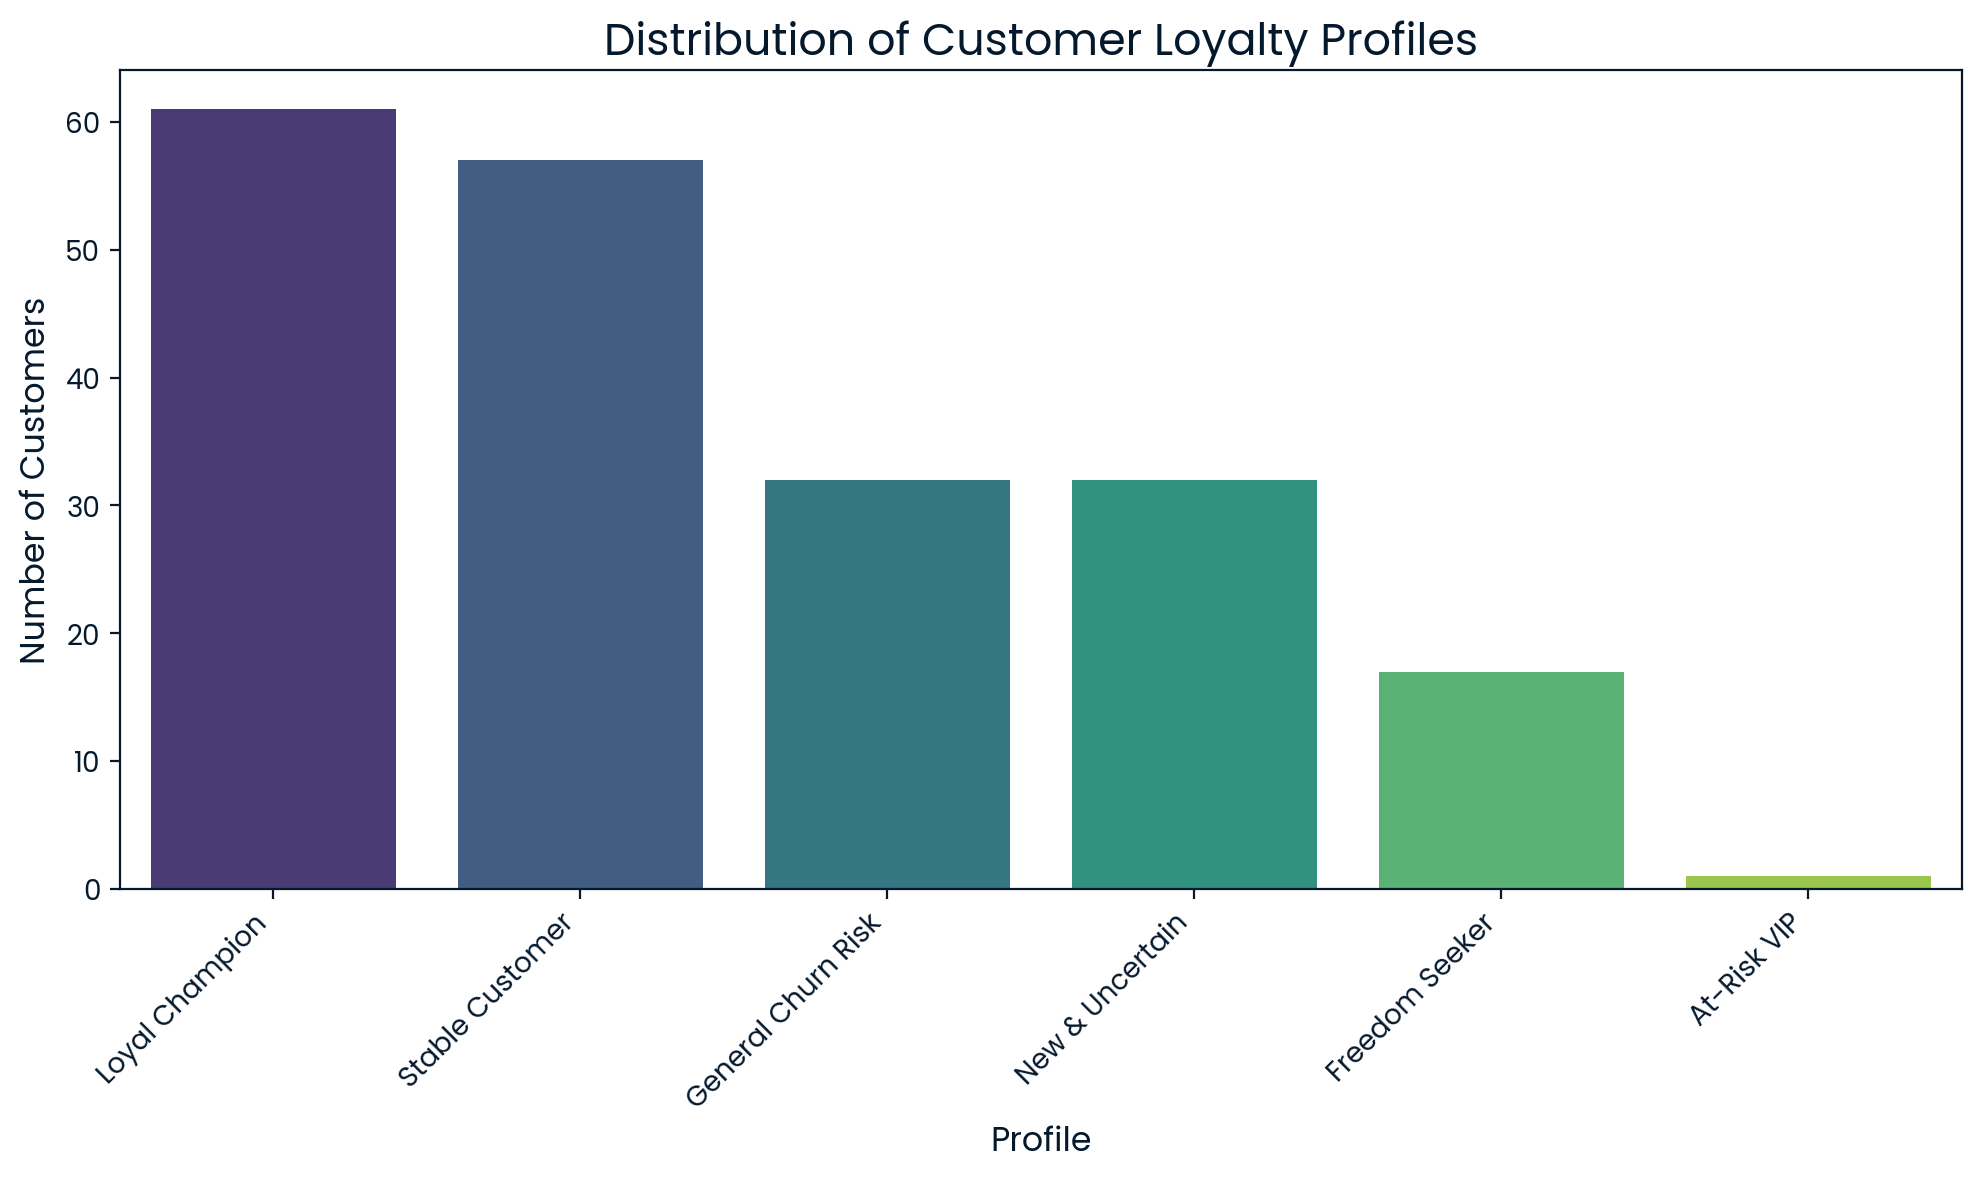

In [9]:
# --- Step 1: Synthesize Data from the Sample ---

# We use the raw, unprocessed sample as the base for our final profiles DataFrame
SAMPLE_SIZE = 200 
if 'X_test_sample_raw' not in locals():
    X_test_sample_raw = shap.sample(X_test, SAMPLE_SIZE)
results_df = X_test_sample_raw.copy()

# Predict probabilities for this specific sample
processed_sample = preprocessor.transform(X_test_sample_raw)
sample_probabilities = nn_model.predict(processed_sample).flatten()
results_df['churn_probability'] = sample_probabilities

# --- Step 2: Create a Correctly Labeled SHAP DataFrame ---

# THE FIX: Get the processed feature names directly from the preprocessor
processed_feature_names = preprocessor.get_feature_names_out()

# Create the SHAP DataFrame with the correct 45 column names and the correct index
# `shap_values` was calculated on the raw sample in the previous step
shap_df = pd.DataFrame(shap_values, columns=processed_feature_names, index=X_test_sample_raw.index)


# --- Step 3: Identify the Primary Driver for each Customer ---

def get_primary_driver(row):
    """Finds the feature with the highest absolute SHAP value for a customer."""
    abs_shap = row.abs()
    primary_driver_feature = abs_shap.idxmax() # This will now be a processed name, e.g., 'cat__Contract_Month-to-month'
    primary_driver_value = row[primary_driver_feature]
    return pd.Series([primary_driver_feature, primary_driver_value], index=['primary_driver', 'driver_shap_value'])

driver_df = shap_df.apply(get_primary_driver, axis=1)

# --- Step 4: Combine the DataFrames ---
# Now `results_df` and `driver_df` have matching indices and can be joined
final_profiles_df = pd.concat([results_df, driver_df], axis=1)


# --- Step 5: Define and Assign Customer Personas (Updated Logic) ---

def assign_loyalty_profile(row):
    """Assigns a persona based on churn probability and the processed primary driver."""
    prob = row['churn_probability']
    driver = row['primary_driver'] # This is now a processed name like 'cat__Contract_Month-to-month'
    tenure = row['tenure']
    
    # High-Risk Profiles
    if prob > 0.5:
        if 'Contract_Month-to-month' in driver:
            return "Freedom Seeker"
        elif 'tenure' in driver and tenure <= 12:
            return "New & Uncertain"
        elif 'InternetService_Fiber optic' in driver or 'MonthlyCharges' in driver:
            return "At-Risk VIP"
        else:
            return "General Churn Risk"
            
    # Low-Risk Profiles
    else:
        if ('Contract_Two year' in driver or 'Contract_One year' in driver) or \
           ('tenure' in driver and tenure >= 36):
            return "Loyal Champion"
        else:
            return "Stable Customer"

final_profiles_df['loyalty_profile'] = final_profiles_df.apply(assign_loyalty_profile, axis=1)


# --- Step 6: Analyze and Display the Segments (Unchanged) ---

print("\nDistribution of Customer Loyalty Profiles (from sample):")
profile_counts = final_profiles_df['loyalty_profile'].value_counts()
print(profile_counts)

plt.figure(figsize=(10, 6))
sns.barplot(x=profile_counts.index, y=profile_counts.values, palette='viridis')
plt.title('Distribution of Customer Loyalty Profiles', fontsize=16)
plt.xlabel('Profile', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig("figures/loyalty_profiles.png", bbox_inches="tight")
plt.show()

Export Profiles Dataset 

In [10]:
# Save the DataFrame to a CSV file
final_profiles_df.to_csv('data/loyalty_profiles.csv', index=False)

# Display the first few rows of the DataFrame
final_profiles_df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,churn_probability,primary_driver,driver_shap_value,loyalty_profile
6457,Male,0,Yes,Yes,17,No,No phone service,DSL,Yes,No,Yes,No,Yes,No,One year,No,Credit card (automatic),44.45,792.15,0.056175,num__tenure,-0.135101,Stable Customer
5560,Male,0,Yes,No,61,Yes,No,Fiber optic,No,Yes,Yes,Yes,No,Yes,Month-to-month,No,Credit card (automatic),94.15,5731.85,0.341382,num__tenure,0.089256,Loyal Champion
6182,Male,0,Yes,Yes,72,Yes,Yes,DSL,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),88.70,6501.35,0.070139,cat__Contract_Month-to-month,-0.072334,Stable Customer
212,Male,0,No,Yes,61,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.75,1124.20,0.022056,num__tenure,0.048982,Loyal Champion
4280,Male,0,Yes,Yes,64,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,Yes,Bank transfer (automatic),19.70,1274.05,0.018370,num__tenure,-0.115270,Loyal Champion
